# CSP Solver am Beispiel Kakuro

```
 *   | s_0 | s_1 |
------------------
 s_2 |  a  |  b  |
------------------
 s_3 |  c  |  d  | 
------------------
```

In [1]:
from qiskit.algorithms import Grover
import numpy as np
from mqt import ddsim
from qiskit import *

In [ ]:
s0_input = 1
s1_input = 3
s2_input = 3
s3_input = 1

In [ ]:

s0_low = QuantumRegister(1, 's0_low')
s0_high = QuantumRegister(1, 's0_high')
s0 = (s0_low, s0_high)
s1_low = QuantumRegister(1, 's1_low')
s1_high = QuantumRegister(1, 's1_high')
s1 = (s1_low, s1_high)
s2_low = QuantumRegister(1, 's2_low')
s2_high = QuantumRegister(1, 's2_high')
s2 = (s2_low, s2_high)
s3_low = QuantumRegister(1, 's3_low')
s3_high = QuantumRegister(1, 's3_high')
s3 = (s3_low, s3_high)

a_low = QuantumRegister(1, 'a_low')
a_high = QuantumRegister(1, 'a_high')
a = (a_low, a_high)
b_low = QuantumRegister(1, 'b_low')
b_high = QuantumRegister(1, 'b_high')
b = (b_low, b_high)
c_low = QuantumRegister(1, 'c_low')
c_high = QuantumRegister(1, 'c_high')
c = (c_low, c_high)
d_low = QuantumRegister(1, 'd_low')
d_high = QuantumRegister(1, 'd_high')
d = (d_low, d_high)

anc = QuantumRegister(32, 'anc')
anc_mct = QuantumRegister(9, 'mct_ancilla')
flag = QuantumRegister(1, 'flag')
qc = QuantumCircuit(a_low, a_high, b_low, b_high, c_low, c_high, d_low, d_high, s0_low, s0_high, s1_low, s1_high, s2_low, s2_high, s3_low, s3_high, anc, anc_mct, flag)
ninputs = 8
nqubits = 17
nancilla = anc.size + anc_mct.size

In [ ]:
nancilla + nqubits

## Encoding of Input Values

In [ ]:

if s0_input == 1:
    qc.x(s0_low)
elif s0_input == 2:
    qc.x(s0_high)
elif s0_input == 3:
    qc.x(s0_low)
    qc.x(s0_high)
    
if s1_input == 1:
    qc.x(s1_low)
elif s1_input == 2:
    qc.x(s1_high)
elif s1_input == 3:
    qc.x(s1_low)
    qc.x(s1_high)
    
if s2_input == 1:
    qc.x(s2_low)
elif s2_input == 2:
    qc.x(s2_high)
elif s2_input == 3:
    qc.x(s2_low)
    qc.x(s2_high)
    
if s3_input == 1:
    qc.x(s3_low)
elif s3_input == 2:
    qc.x(s3_high)
elif s3_input == 3:
    qc.x(s3_low)
    qc.x(s3_high)

## Function Definition for Inequality, equality and addition

In [18]:
def check_equality(qc, x, y, res_anc):
    x_low, x_high = x
    y_low, y_high = y
    
    qc.cx(x_high, y_high)
    qc.x(y_high)
    qc.cx(x_low, y_low)
    qc.x(y_low)
    
    qc.rccx(y_low, y_high, res_anc)
    
    #Uncompute
    qc.x(y_low)
    qc.cx(x_low, y_low)
    qc.x(y_high)
    qc.cx(x_high, y_high)

def check_inequality(qc, x, y, res_anc):
    check_equality(qc, x, y, res_anc)
    qc.x(res_anc)


def add_two_numbers(qc, x, y, ancs, res_anc_low, res_anc_high):
    x_low, x_high = x
    y_low, y_high = y
    
    qc.cx(x_low, y_low)
    qc.cx(y_low, res_anc_low)
    qc.rccx(x_low, y_low, ancs[0])
    qc.cx(x_high, y_high)
    qc.cx(y_high, ancs[1])
    qc.x(ancs[0])
    qc.x(ancs[1])
    
    qc.rccx(ancs[0], ancs[1], res_anc_high)

    #Uncompute
    qc.x(ancs[0])
    qc.x(ancs[1])
    qc.cx(y_high, ancs[1])
    qc.cx(x_high, y_high)
    qc.rccx(x_low, y_low, ancs[0])
    qc.cx(y_low, res_anc_low)
    qc.cx(x_low, y_low)
    

    
    return (res_anc_low, res_anc_high)

# Check Functions and their result

## Inequality

In [19]:
for i in range(2**4):

    t1_low = QuantumRegister(1, 't1_low')
    t1_high = QuantumRegister(1, 't1_high')
    t1 = (t1_low, t1_high)
    t2_low = QuantumRegister(1, 't2_low')
    t2_high = QuantumRegister(1, 't2_high')
    t2 = (t2_low, t2_high)
    t_anc = QuantumRegister(1, 't_anc')
    t_anc_classical = ClassicalRegister(1, 't_anc_classical')
       
    qc_test_inequality = QuantumCircuit(t1_low, t1_high, t2_low, t2_high, t_anc, t_anc_classical)
    for j in range(4):
        if (i>>j) % 2 == 1:
            qc_test_inequality.x(j)

    check_inequality(qc_test_inequality, t1, t2, t_anc)
    qc_test_inequality.measure(t_anc, t_anc_classical)

    backend = ddsim.DDSIMProvider().get_backend('qasm_simulator')
    job = execute(qc_test_inequality, backend, shots=10)
    counts = job.result().get_counts(qc_test_inequality)
    print("{0:b}".format(i), counts)

0 {'0': 10}
1 {'1': 10}
10 {'1': 10}
11 {'1': 10}
100 {'1': 10}
101 {'0': 10}
110 {'1': 10}
111 {'1': 10}
1000 {'1': 10}
1001 {'1': 10}
1010 {'0': 10}
1011 {'1': 10}
1100 {'1': 10}
1101 {'1': 10}
1110 {'1': 10}
1111 {'0': 10}


## Equality

In [20]:
for i in range(2**4):

    t1_low = QuantumRegister(1, 't1_low')
    t1_high = QuantumRegister(1, 't1_high')
    t1 = (t1_low, t1_high)
    t2_low = QuantumRegister(1, 't2_low')
    t2_high = QuantumRegister(1, 't2_high')
    t2 = (t2_low, t2_high)
    t_anc = QuantumRegister(1, 't_anc')
    t_anc_classical = ClassicalRegister(1, 't_anc_classical')
       
    qc_test_equality = QuantumCircuit(t1_low, t1_high, t2_low, t2_high, t_anc, t_anc_classical)
    for j in range(4):
        if (i>>j) % 2 == 1:
            qc_test_equality.x(j)




    check_equality(qc_test_equality, t1, t2, t_anc)
    qc_test_equality.measure(t_anc, t_anc_classical)

    backend = ddsim.DDSIMProvider().get_backend('qasm_simulator')
    job = execute(qc_test_equality, backend, shots=10)
    counts = job.result().get_counts(qc_test_equality)
    print("{0:b}".format(i), counts)

0 {'1': 10}
1 {'0': 10}
10 {'0': 10}
11 {'0': 10}
100 {'0': 10}
101 {'1': 10}
110 {'0': 10}
111 {'0': 10}
1000 {'0': 10}
1001 {'0': 10}
1010 {'1': 10}
1011 {'0': 10}
1100 {'0': 10}
1101 {'0': 10}
1110 {'0': 10}
1111 {'1': 10}


## Addition

{'1 0': 10}


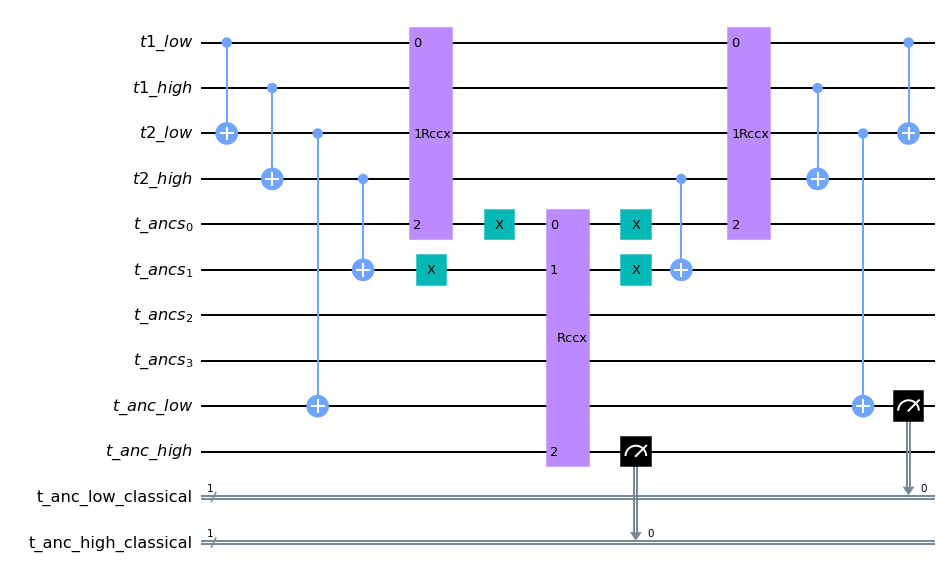

In [21]:
t1_low = QuantumRegister(1, 't1_low')
t1_high = QuantumRegister(1, 't1_high')
t1 = (t1_low, t1_high)
t2_low = QuantumRegister(1, 't2_low')
t2_high = QuantumRegister(1, 't2_high')
t2 = (t2_low, t2_high)
t_ancs = QuantumRegister(4, 't_ancs')
t_anc_low = QuantumRegister(1, 't_anc_low')
t_anc_low_classical = ClassicalRegister(1, 't_anc_low_classical')
t_anc_high = QuantumRegister(1, 't_anc_high')
t_anc_high_classical = ClassicalRegister(1, 't_anc_high_classical')

qc_test_adittion = QuantumCircuit(t1_low, t1_high, t2_low, t2_high, t_ancs, t_anc_low, t_anc_high, t_anc_low_classical, t_anc_high_classical)

tmp_1 = add_two_numbers(qc_test_adittion, t1, t2, t_ancs, t_anc_low, t_anc_high)

qc_test_adittion.measure(t_anc_low, t_anc_low_classical)
qc_test_adittion.measure(t_anc_high, t_anc_high_classical)

backend = ddsim.DDSIMProvider().get_backend('qasm_simulator')
job = execute(qc_test_adittion, backend, shots=10)
counts = job.result().get_counts(qc_test_adittion)
print(counts)

qc_test_adittion.draw(output='mpl', fold=-1)

# Encoding of Constraints

In [ ]:
mct_list=[]

# Inequalities
check_inequality(qc, a, b, anc[0])
mct_list.append(anc[0])
check_inequality(qc, b, d, anc[1])
mct_list.append(anc[1])
check_inequality(qc, d, c, anc[2])
mct_list.append(anc[2])
check_inequality(qc, c, a, anc[3])
mct_list.append(anc[3])


# Equalities
tmp_1 = add_two_numbers(qc, a, b, anc[4:8], anc[8], anc[9])
check_equality(qc, s2, tmp_1, anc[10])
mct_list.append(anc[10])

tmp_2 = add_two_numbers(qc, c, d, anc[11:15], anc[15], anc[16])
check_equality(qc, s3, tmp_2, anc[17])
mct_list.append(anc[17])

tmp_3 = add_two_numbers(qc, b, d, anc[18:22], anc[22], anc[23])
check_equality(qc, s1, tmp_3, anc[24])
mct_list.append(anc[24])

tmp_4 = add_two_numbers(qc, a, c, anc[25:29], anc[29], anc[30])
check_equality(qc, s0, tmp_4, anc[31])
mct_list.append(anc[31])

# Create Oracle

In [ ]:
compute = qc.to_instruction()

# mark solution
qc.mct(mct_list, flag, ancilla_qubits=anc_mct, mode='v-chain')

# uncompute
uncompute = compute.inverse()
uncompute.name = 'uncompute'
qc.append(uncompute, range(qc.num_qubits))


print("Complete Oracle (CX): ", transpile(qc, basis_gates=['u', 'cx']).count_ops()['cx'])
print("Complete Oracle (U): ", transpile(qc, basis_gates=['u', 'cx']).count_ops()['u'])
oracle = qc.to_instruction(label='oracle')
qc.draw(output='mpl', fold=-1)

# Testing the Oracle

In [ ]:
from qiskit.algorithms import Grover
import numpy as np
from mqt import ddsim
backend = ddsim.DDSIMProvider().get_backend('qasm_simulator')
print(nqubits+nancilla, oracle.num_qubits)
for i in range(2**8):
    new = QuantumCircuit(nqubits+nancilla, 1)
    for j in range(8):
        if (i>>j) % 2 == 1:
            new.x(j)
    new.append(oracle, range(nqubits+nancilla))
    new.measure(57, 0)

    job = execute(new, backend, shots=10)
    counts = job.result().get_counts(new)
    print("{0:b}".format(i), counts)
    #if counts.get("1"):
        #print("{0:b}".format(i), counts)


# Embedding in Grover Algorithm

In [ ]:
from qiskit.algorithms import Grover
import numpy as np
from mqt import ddsim

qc = QuantumCircuit(nqubits+nancilla, ninputs)
qc.h(range(ninputs))
qc.x(nqubits+nancilla-1)
qc.h(nqubits+nancilla-1)

num_iterations = Grover.optimal_num_iterations(1, ninputs)

#print(num_iterations)
for _ in range(num_iterations):
    qc.append(oracle, range(nqubits+nancilla))
    qc.h(range(ninputs))
    qc.x(range(ninputs))
    qc.mcp(np.pi, list(range(ninputs-1)), ninputs-1)
    qc.x(range(ninputs))
    qc.h(range(ninputs))
qc.measure(range(ninputs), range(ninputs))
qc.qasm(filename='grover_algorithm.qasm')

backend = ddsim.DDSIMProvider().get_backend('qasm_simulator')
job = execute(qc, backend, shots=1)
counts = job.result().get_counts(qc)
print(counts)

# Archiv: Classiq

In [ ]:
qc = QuantumCircuit(x0, x1, x2, x3MSQ, x3LSQ, x4, x5, x6, anc, anc_mct, flag)

# (x0 != x1) -> anc[0]
qc.cx(x0,x1)
qc.cx(x1,anc[0])
qc.cx(x0,x1)
qc.barrier()

# (x5 != x6) -> anc[1]
qc.cx(x5,x6)
qc.cx(x6,anc[1])
qc.cx(x5,x6)
qc.barrier()

# (x0 != x2) -> anc[2]
qc.cx(x0,x2)
qc.cx(x2,anc[2])
qc.cx(x0,x2)
qc.barrier()

# (x1 != x5) -> anc[3]
qc.cx(x1,x5)
qc.cx(x5,anc[3])
qc.cx(x1,x5)
qc.barrier()

# (x4 != x6) -> anc[4]
qc.cx(x4,x6)
qc.cx(x6,anc[4])
qc.cx(x4,x6)
qc.barrier()

# (x3 != x4) -> anc[5]
qc.cx(x3LSQ, x4)
qc.x(x4)
qc.x(x3MSQ)
qc.rccx(x3MSQ, x4, anc[5])
qc.x(x4)
qc.cx(x3LSQ, x4)
qc.x(x3MSQ)
qc.x(anc[5])
qc.barrier()

# (x1 != x3) -> anc[6]
qc.cx(x3LSQ, x1)
qc.x(x1)
qc.x(x3MSQ)
qc.rccx(x3MSQ, x1, anc[6])
qc.x(x1)
qc.cx(x3LSQ, x1)
qc.x(x3MSQ)
qc.x(anc[6])
qc.barrier()

# (x3 != x5) -> anc[7]
qc.cx(x3LSQ, x5)
qc.x(x5)
qc.x(x3MSQ)
qc.rccx(x3MSQ, x5, anc[7])
qc.x(x5)
qc.cx(x3LSQ, x5)
qc.x(x3MSQ)
qc.x(anc[7])
qc.barrier()

# (x3 == 2) -> anc[8]
qc.x(x3LSQ)
qc.rccx(x3LSQ, x3MSQ, anc[8])
qc.x(x3LSQ)
qc.barrier()

# (x2 + 2 != x3) -> anc[9]
qc.cx(x2, x3LSQ)
qc.x(x3LSQ)
qc.rccx(x3MSQ, x3LSQ, anc[9])
qc.x(x3LSQ)
qc.x(anc[9])
qc.cx(x2, x3LSQ)
qc.barrier()


# (x2 + x4 + x3 == 3) -> anc[10]
qc.rccx(x3LSQ, x2, anc[11])
qc.cx(x3LSQ, x2)
qc.rccx(x2, x4, anc[11])
qc.cx(x2, x4)
qc.rccx(x3MSQ, anc[11], anc[12])
qc.cx(x3MSQ, anc[11])
qc.x(anc[12])

qc.rcccx(x4, anc[11], anc[12], anc[10])

qc.x(anc[12])
qc.cx(x3MSQ, anc[11])
qc.rccx(x3MSQ, anc[11], anc[12])
qc.cx(x2, x4)
qc.rccx(x2, x4, anc[11])
qc.cx(x3LSQ, x2)
qc.rccx(x3LSQ, x2, anc[11])
qc.barrier()

compute = qc.to_instruction()

# mark solution
qc.mct(anc[0:ncond], flag, ancilla_qubits=anc_mct, mode='v-chain')

# uncompute
uncompute = compute.inverse()
uncompute.name = 'uncompute'
qc.append(uncompute, range(qc.num_qubits))

print("Complete Oracle (CX): ", transpile(qc, basis_gates=['u', 'cx']).count_ops()['cx'])
print("Complete Oracle (U): ", transpile(qc, basis_gates=['u', 'cx']).count_ops()['u'])

qc.qasm(filename='oracle.qasm')
oracle = qc.to_instruction(label='oracle')
qc.draw(fold=-1, output='mpl')

In [ ]:
from qiskit.algorithms import Grover
import numpy as np
from mqt import ddsim

qc = QuantumCircuit(nqubits+nancilla, ninputs)
qc.h(range(ninputs))
qc.x(nqubits+nancilla-1)
qc.h(nqubits+nancilla-1)

num_iterations = Grover.optimal_num_iterations(1, ninputs)

#print(num_iterations)
for _ in range(num_iterations):
    qc.append(oracle, range(nqubits+nancilla))
    qc.h(range(ninputs))
    qc.x(range(ninputs))
    qc.mcp(np.pi, list(range(ninputs-1)), ninputs-1)
    qc.x(range(ninputs))
    qc.h(range(ninputs))
qc.measure(range(ninputs), range(ninputs))
qc.qasm(filename='grover_algorithm.qasm')

backend = ddsim.DDSIMProvider().get_backend('qasm_simulator')
job = execute(qc, backend, shots=10000)
counts = job.result().get_counts(qc)
print(counts)

In [ ]:
qc.draw(fold=-1, output='mpl')

# Straight-forward Oracle Definition

In the following, all constraints are combined in a sequential fashion and a large multi-controlled Toffoli gate is used to mark the desired states. Then all constraints are properly uncomputed again.